# **Segmentation**

This is the segmentation notebook which was originally written in spanish.

The goal of this notebook is to test different segmentation method and
to study different segmentation metrics.

In [1]:
import os
import cv2
import random
import csv
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import morphology, measure
from skimage import filters, color
import tqdm.auto as tqdm
from PIL import Image, ImageDraw

In [9]:
DATA_DIR = os.path.join('..', 'data', 'datasets', 'yacine', 'original_splits')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALIDATION_DIR = os.path.join(DATA_DIR, 'validation')
FEATURES_DIR = os.path.join(DATA_DIR, 'features')
POSITIVE_LABEL = 'pools'
NEGATIVE_LABEL = 'no_pools'
TAGGED_IMAGES_PATH = os.path.join('..', 'results', 'pool_annotation_train_img-0-30.csv')

USE_CACHE = False
PLOT_RESULTS = False
SEED = 2
random.seed(SEED)

## **Auxiliar Functions**:

### **Analysis**

In [10]:
from matplotlib import colors

def scatter_plot_rgb(imag, axs=None):
    r, g, b = cv2.split(imag)
    pixel_colors = imag.reshape((np.shape(imag)[0]*np.shape(imag)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()

    if axs is None:
        fig = plt.figure()
        axs = fig.add_subplot(1,1,1, projection="3d")

    axs.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
    axs.set_xlabel("Red")
    axs.set_ylabel("Green")
    axs.set_zlabel("Blue")
    axs.set_title("RGB Scatter Plot")

def scatter_plot_hsv(imag, axs=None):
    hsv_imag = cv2.cvtColor(imag, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_imag)
    pixel_colors = imag.reshape((np.shape(imag)[0]*np.shape(imag)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()
    if axs is None:
        fig = plt.figure()
        axs = fig.add_subplot(1,1,1, projection="3d")
    axs.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
    axs.set_xlabel("Hue")
    axs.set_ylabel("Saturation")
    axs.set_zlabel("Value")
    axs.set_title("HSV Scatter Plot")
    return hsv_imag

### **Utils**

In [11]:
def interpolate_image_size(image, prop_size, interpolation):
    ''' 
    Increase/decrease the size of the image by a given proportion, using the given interpolation method
    '''
    height, width = (image.shape[:2])
    return cv2.resize(image, (int(width), int(height)), interpolation=interpolation)


def draw_mask_contour(image, mask):  
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    out = image.copy()
    cv2.drawContours(out, contours, -1, (0,255,0), 1)
    return out

class pipeline:
    def __init__(self) -> None:
        self.operations = []
    
    def __repr__(self):
        operation_names = [op.__name__ for op in self.operations][::-1]
        par = [')' for _ in range(len(self.operations) - 1)]
        return f"ImageProcessingPipeline: {'('.join(operation_names)}(image{''.join(par)})"

    def add_operation(self, operation):
        self.operations.append(operation)
    
    def remove_operation(self, operation):
        self.operations.remove(operation)
    
    def apply(self, image, verbose=False):
        img = image.copy()
        if verbose:
            plt.figure()
            plt.title("Original")
            plt.imshow(img)
            plt.show()
        for operation in tqdm.tqdm(self.operations, desc="Processing", unit="operation",disable=True):
            img = operation(img)
            if(verbose):
                plt.figure()
                plt.imshow(img)
                plt.show()
        return img

### MEDIDAS

In [12]:
def image_matching(image, mask): 
    """
    This function computes the matching of the image by the mask
    """
    intersection = np.sum(np.where(image * mask > 0, 1, 0))
    return intersection / np.sum(np.where(mask > 0, 1, 0))

def jaccard_index(imagen_referencia, imagen_segmentacion):
    # Convertir las imágenes a arreglos NumPy binarios
    referencia_binaria = np.asarray(imagen_referencia).astype(bool)
    segmentacion_binaria = np.asarray(imagen_segmentacion).astype(bool)

    # Calcular el tamaño de la intersección y la unión
    interseccion = np.logical_and(referencia_binaria, segmentacion_binaria)
    union = np.logical_or(referencia_binaria, segmentacion_binaria)

    # Calcular el índice de Jaccard
    jaccard = np.sum(interseccion) / np.sum(union)

    return jaccard

def test_mask_results(results_path, pipe: pipeline):
    results = []
    with open(results_path, 'r') as results_csv:
        reader_csv = csv.DictReader(results_csv)
        for row in reader_csv:
            imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', row["filename"]))            
            binary = pipe.apply(imag, False)

            region_attr = eval(row["region_shape_attributes"])
            shape_teo = list(zip(region_attr['all_points_x'], region_attr['all_points_y']))
            mask_teo = Image.new("RGB", binary.shape, "black")
            dibujo_teo = ImageDraw.Draw(mask_teo)
            dibujo_teo.polygon(shape_teo, outline="white", fill="white")
            mask_teo = cv2.cvtColor(np.array(mask_teo), cv2.COLOR_RGB2GRAY)

            results.append(jaccard_index(mask_teo, binary))
    return results

### SEGMENTADORES

In [13]:
def otsu_threshold(image):
    gray = color.rgb2gray(np.array(image))
    threshold = filters.threshold_otsu(gray)
    return gray > threshold

def simple_threshold(gray, threshold=0):
    return gray > threshold

def kmeans_segmentation(image, k = 3):
    pixel_vals = image.reshape((-1,3))

    # Convert to float type
    pixel_vals = np.float32(pixel_vals)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
    
    # Perform the k-means clustering
    retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    
    # convert data into 8-bit values
    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    
    # reshape data into the original image dimensions
    segmented_image = segmented_data.reshape((image.shape))
    
    return segmented_image

def kmeans_segmentation2(image_bgr, k = 3):
    # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
    image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    pixel_vals = image.reshape((-1,3))

    # Convert to float and perform K-means
    pixel_vals = np.float32(pixel_vals)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
    _, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Convert data into 8-bit values
    centers = np.uint8(centers)
    res = [image_bgr]
    for i in range(k):
        temp = np.zeros(centers.shape, np.uint8)
        temp[i] = centers[i]
        res.append((temp[labels.flatten()]).reshape((image.shape)))
    return res, centers

def keep_most_blue_component(kmeans_results, Print=False, is_hsv=False):
    res, _ = kmeans_results
    blue_mask = keep_blue(res[0], is_hsv=is_hsv) > 0
    max_jaccard = 0
    blue_mask_res = np.zeros(blue_mask.shape[:2])

    #If there is not a blue component, return an empty mask
    for i in range(1, len(res)):
        jaccard = jaccard_index(blue_mask, res[i])
        if jaccard > max_jaccard:
            max_jaccard = jaccard
            blue_mask_res = res[i]
    if(Print):
        plt.imshow(blue_mask_res)
        plt.title("Blue mask result")
        plt.show()

    return blue_mask_res
        
def morfology_cleaning(image):
    cleaned = morphology.remove_small_objects(image, min_size=200)
    return cleaned

def morfology_absorption(image, size=5):
    absorption = morphology.binary_dilation(image, morphology.disk(size))
    absorption = morphology.binary_erosion(absorption, morphology.disk(size))
    return absorption

def morfology_closing(binary):
    binaryInt8 = binary.astype(np.uint8)
    kernel = np.ones((5,5), np.uint8)
    binaryInt8 = cv2.morphologyEx(binaryInt8, cv2.MORPH_CLOSE, kernel)
    return binaryInt8

def keep_blue(image, Print=False, is_hsv=False):
    if not is_hsv:
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    else:
        hsv = image
    lower_blue = np.array([90,50,50])
    upper_blue = np.array([250,255,255])

    # Blue color mask
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    res = cv2.bitwise_and(image,image, mask= mask)

    if(Print):
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(1, 3, 1)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax1.imshow(image_rgb)
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.imshow(mask, cmap='gray')
        ax3 = fig.add_subplot(1, 3, 3)
        res_rgb = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
        ax3.imshow(res_rgb)
    return res

def to_grayscale(image):
    if all(pixel == 0 for pixel in image.flatten()):
        return image
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def to_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

### **Metrics**

In [14]:

def display_image_mask(image, mask, title=None):
    if title:
        print()
        print(title)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axs[0].matshow(image)
    axs[1].matshow(mask, cmap='gray')
    axs[0].set_title("Original")
    axs[1].set_title("Processed")
    plt.axis('off')
    plt.show()

def obtain_measured_mask(img_name, results_path, mask_shape):
    '''
    This function obtains the mask of the image with the given name from the results path
    '''
    with open(results_path, 'r') as results_csv:
        reader_csv = csv.DictReader(results_csv)
        for row in reader_csv:
            if row['filename'] == img_name:
                region_attr = eval(row["region_shape_attributes"])
                mask_verts = list(zip(region_attr['all_points_x'], region_attr['all_points_y']))

                mask = Image.new("RGB", mask_shape, "black")
                mask_draw = ImageDraw.Draw(mask)
                mask_draw.polygon(mask_verts, outline="white", fill="white")
                mask = cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY)
                
                return mask

## **Color Space**

A continuacion se observa el espacio de color RGB y HSV para una muestra de imagene con piscina. Es interesante observar como en el espacio de color HSV, los pixeles correspondientes a las piscinas se aglomeran en regiones más claramente distanciadas del resto de la imagen en comparación al espacio de color RGB. Esto se debe a que el espacio de color HSV realiza una separación más definida de los colores por tono en comparación a RGB, lo que se traduce en una mayor facilidad para separar los pixeles de la piscina del resto de la imagen.

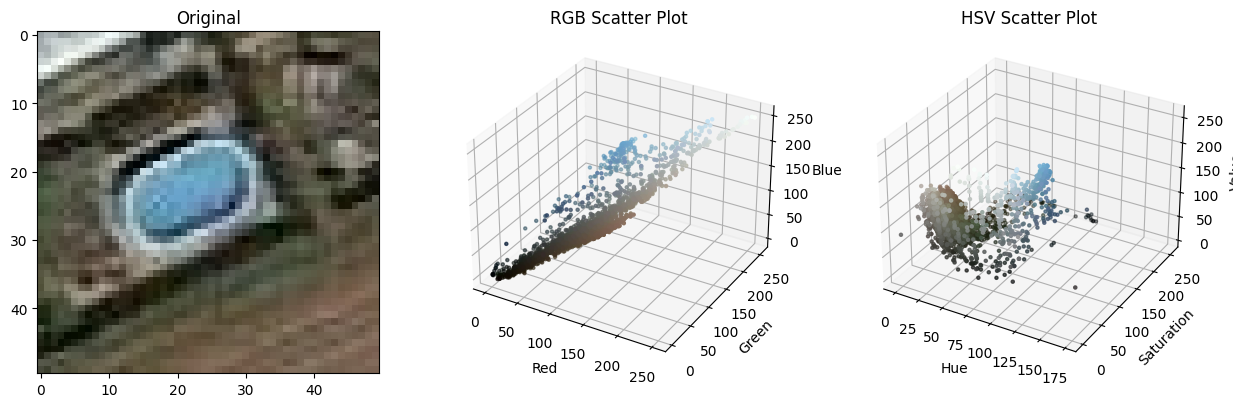

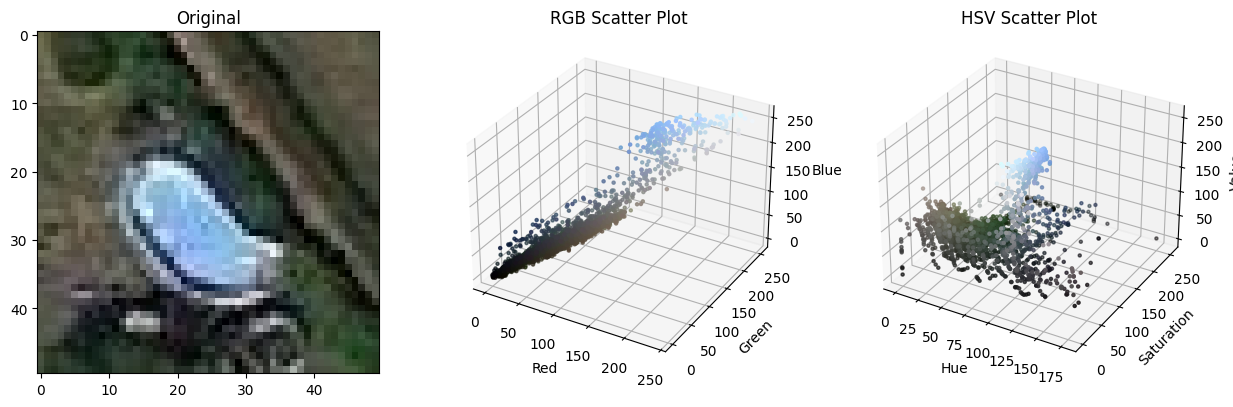

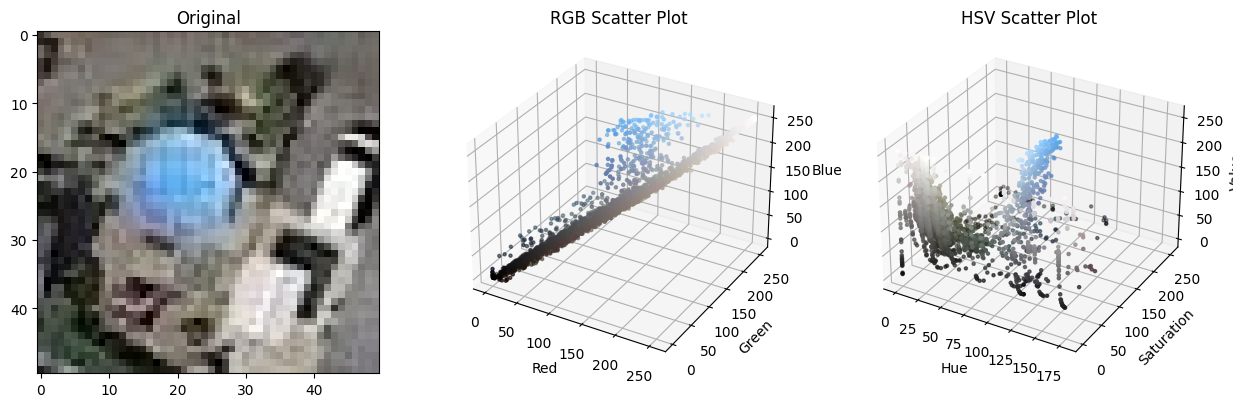

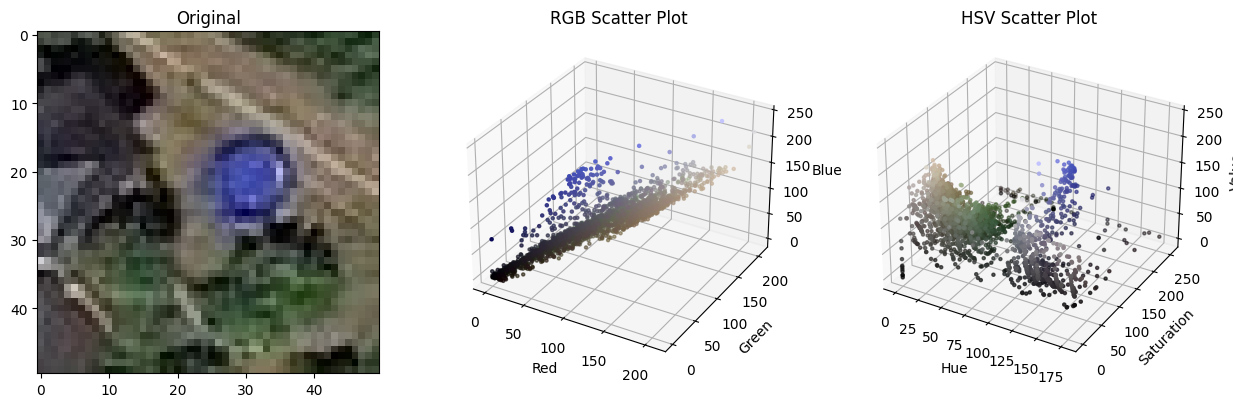

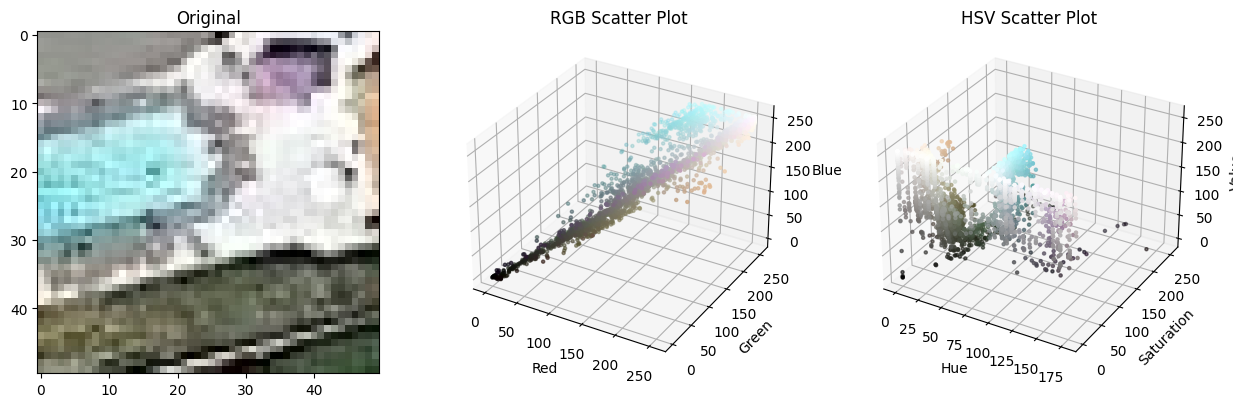

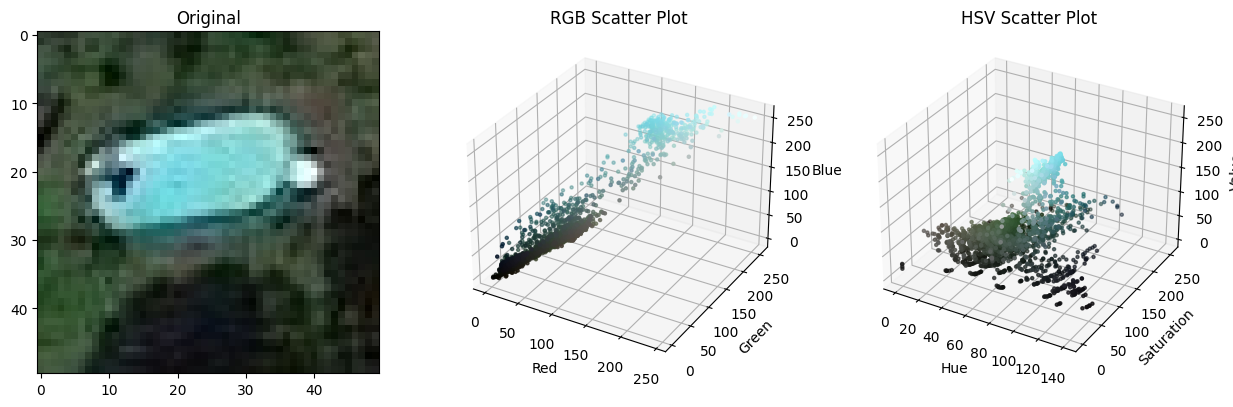

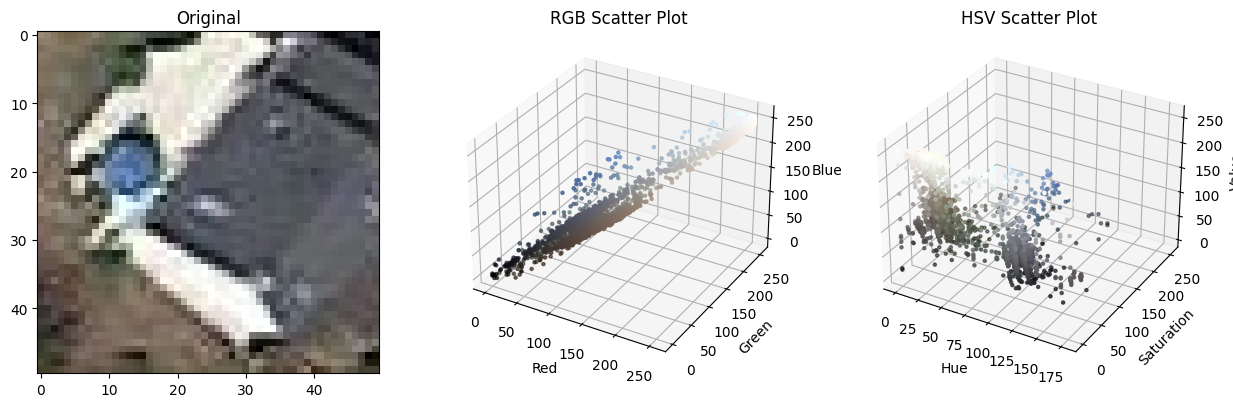

In [15]:

images = ['img29.jpg','img0.jpg', 'img1.jpg', 'img11.jpg','img16.jpg', 'img1454.jpg', 'img680.jpg']

light_blue = (250,255,255)
dark_blue = (90,50,50)

lo_square = np.full((10, 10, 3), light_blue, dtype=np.uint8)
do_square = np.full((10, 10, 3), dark_blue, dtype=np.uint8)

lo_square_rgb = cv2.cvtColor(lo_square, cv2.COLOR_BGR2RGB)
do_square_rgb = cv2.cvtColor(do_square, cv2.COLOR_BGR2RGB)

for image_name in images:
    imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', image_name))
    
    image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_title("Original")
    ax1.imshow(image_rgb)
    
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    scatter_plot_rgb(image_rgb.copy(), ax2)

    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    scatter_plot_hsv(image_rgb.copy(), ax3)
    
    plt.show()

## **Segmentators**


En esta seccion se mostraran algunas estrategias que fueron utilizadas para intentar segmentar las piscinas, se compararan los resultados obtenidos ya sea entre ellos, como contra algunas mascaras previamente generadas manualmente utilizando la herramienta VGG.

### **KEEP_BLUE**

Como primer paso, se observan los resultados de segmentar exclusivamente por el color azul, aplicando luego dos tipos de umbralización, en primer lugar una umbralización simple para convertir el resultado obtenido en una máscara binaria, y en segundo lugar una umbralización adaptativa (el método de Otsu) que depende de la distribución del histograma en la región hallada. 


ImageProcessingPipeline: morfology_closing(simple_threshold(to_grayscale(keep_blue(image))))


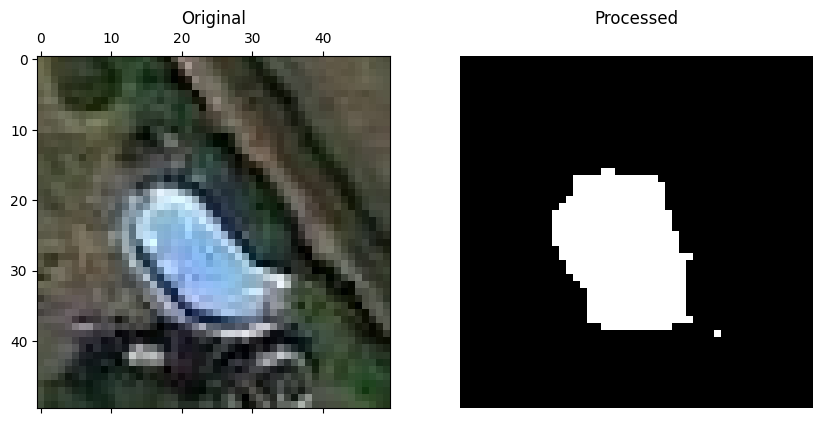

Indice de Jaccard:  0.6840579710144927
Cobertura de imagen: 0.9752066115702479

ImageProcessingPipeline: morfology_closing(simple_threshold(to_grayscale(keep_blue(image))))


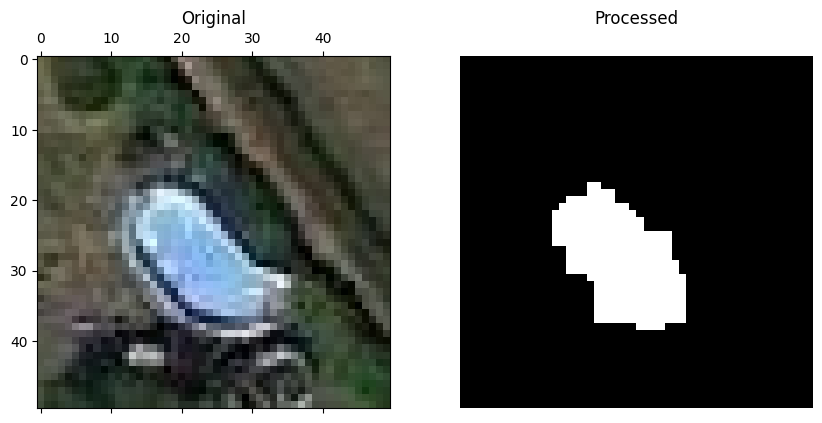

Indice de Jaccard:  0.8401486988847584
Cobertura de imagen: 0.9338842975206612


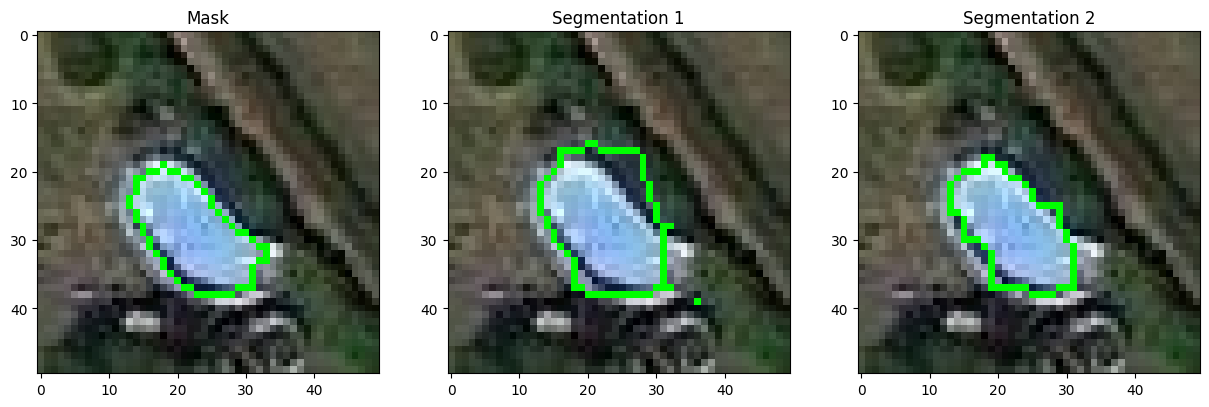

In [16]:
image_bgr = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img0.jpg'))
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
mask = obtain_measured_mask('img0.jpg', TAGGED_IMAGES_PATH, gray.shape)

pipe = pipeline()
pipe.add_operation(keep_blue)
pipe.add_operation(to_grayscale)
pipe.add_operation(simple_threshold)
pipe.add_operation(morfology_closing)
binary = pipe.apply(image_rgb, False)
display_image_mask(image_rgb, binary, title=pipe)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))


pipe2 = pipeline()
pipe2.add_operation(keep_blue)
pipe2.add_operation(otsu_threshold)
pipe2.add_operation(morfology_closing)
binary2 = pipe2.apply(image_rgb, False)
display_image_mask(image_rgb, binary2, title=pipe)
print('Indice de Jaccard: ', jaccard_index(mask, binary2))
print('Cobertura de imagen:', image_matching(binary2, mask))


image_mask = draw_mask_contour(image_rgb, mask)
image_segmentation1 = draw_mask_contour(image_rgb, binary)
image_segmentation2 = draw_mask_contour(image_rgb, binary2)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axs[0].imshow(image_mask)
axs[0].set_title("Mask")
axs[1].imshow(image_segmentation1)
axs[1].set_title("Segmentation 1")
axs[2].imshow(image_segmentation2)
axs[2].set_title("Segmentation 2")
plt.show()


### **OTSU THRESHOLDING**

Para entender la función del método de Otsu en esta implementación, se puede observar los siguientes ejemplos, en que se aplica el mismo pero sin obtener primero la región más azul de la imagen. Como se observó anteriormente, este algoritmo sirve para obtener la componente más "destacada" de la imagen, lo cual puede servir por si solo en algunos casos, como se ve en el segundo ejemplo. Sin embargo, en el primer ejemplo, se observa que el método de Otsu no es suficiente para segmentar la piscina, ya que la componente más destacada de la imagen no es la piscina. Este es el motivo por el cual se aplica primero el método de obtener la región más azul de la imagen, ya que de esta manera es posible restringir la región de la imagen en la que se aplica el método de Otsu, obteniendo así mejores resultados.

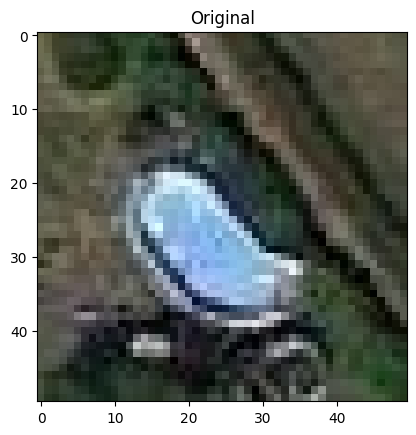

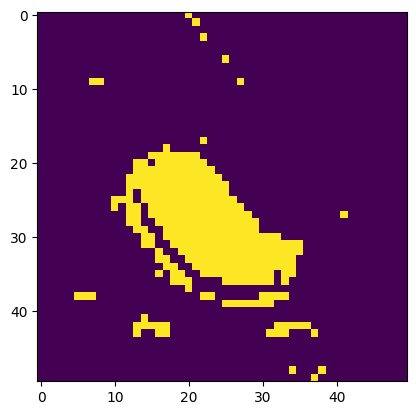

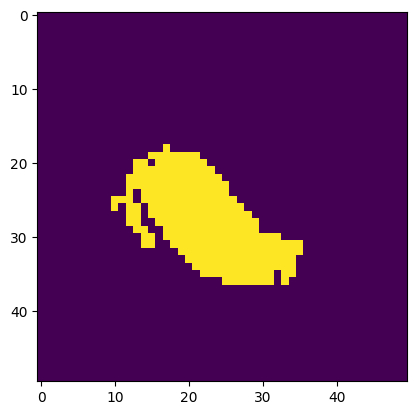

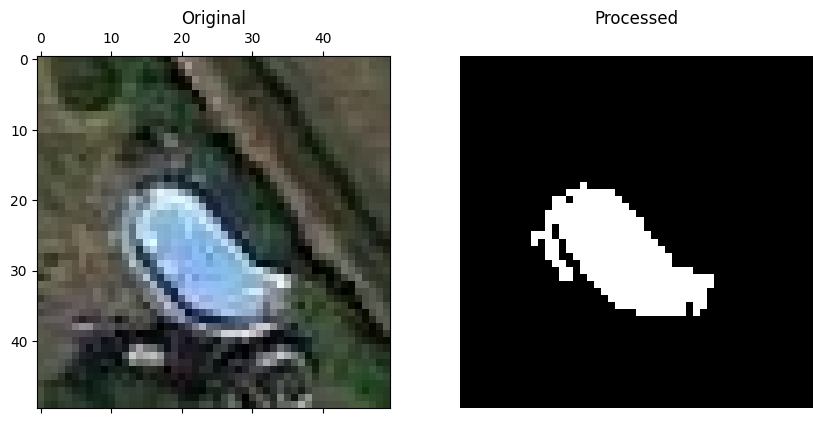

In [17]:
pipe3 = pipeline()
pipe3.add_operation(otsu_threshold)
pipe3.add_operation(morfology_cleaning)
binary = pipe3.apply(image_rgb, True)
display_image_mask(image_rgb, binary)

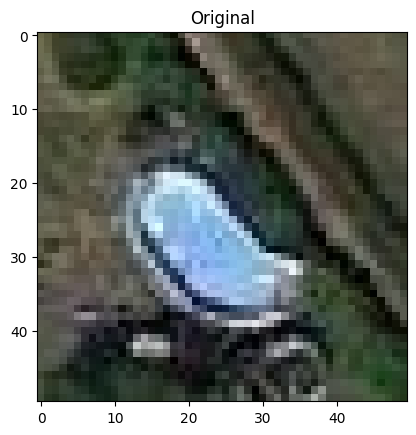

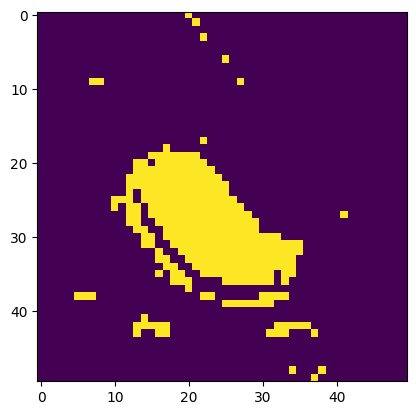

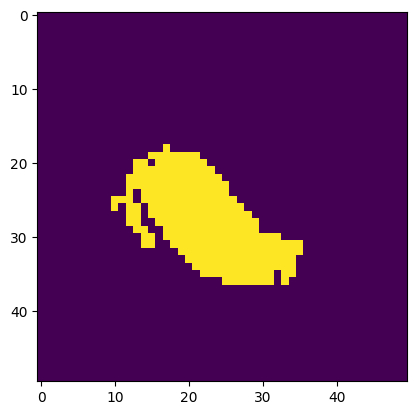

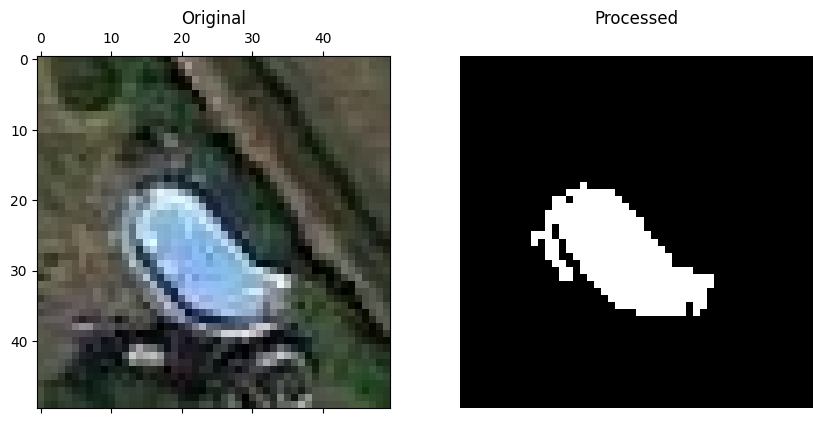

In [18]:
image_bgr = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img0.jpg'))
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
mask = obtain_measured_mask('img0.jpg', TAGGED_IMAGES_PATH, gray.shape)

binary = pipe3.apply(image_rgb, True)
display_image_mask(image_rgb, binary)

### **K-MEANS (RGB)**

#### **K-means simple**

Otra manera estudiada para separar las componentes de la imagen es el uso de k-means para separar la imagen en diferentes clases. En este caso, se utilizó primero el espacio de color RGB para realizar la segmentación y estudiar los resultados obtenidos. Se verá como en algunos casos al variar el valor de k es posible obtener clases que contienen principalmente al conjunto de pixeles que componen la región buscada de la imagen.


ImageProcessingPipeline: kmeans_segmentation(image)


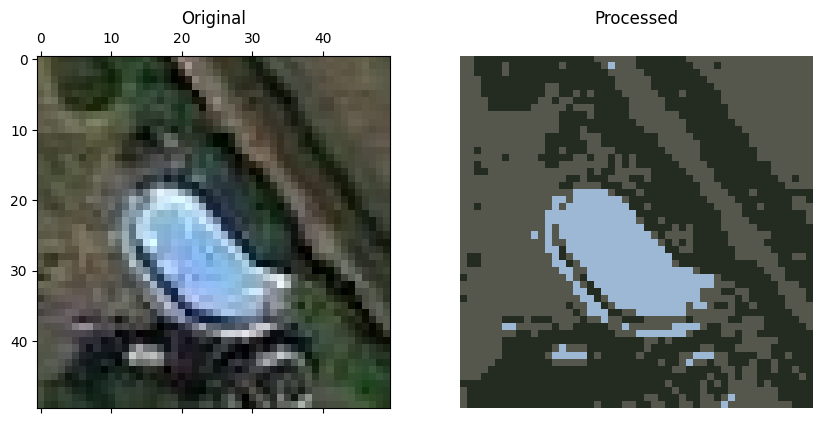

In [19]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img0.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

pipe1 = pipeline()
pipe1.add_operation(kmeans_segmentation)
segmented = pipe1.apply(image_rgb, False)
display_image_mask(image_rgb, segmented, title=pipe1)


ImageProcessingPipeline: kmeans_segmentation(image)


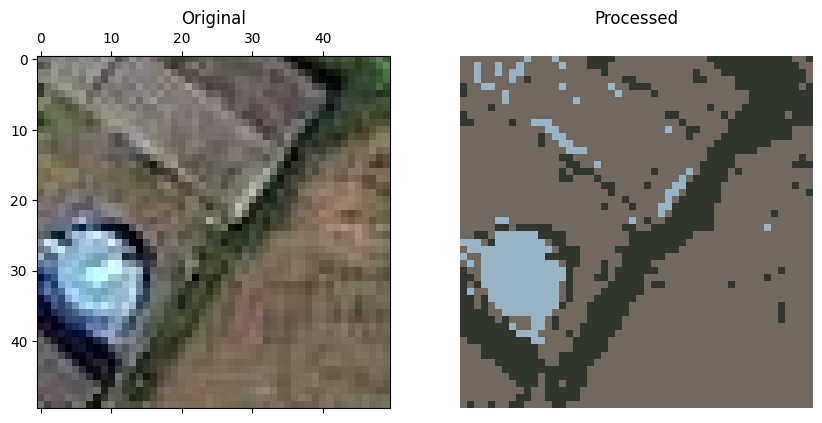

In [20]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img10.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

pipe1 = pipeline()
pipe1.add_operation(kmeans_segmentation)
segmented = pipe1.apply(image_rgb, False)
display_image_mask(image_rgb, segmented, title=pipe1)

#### **K-means using Otsu Thresholding**

En los resultados siguientes se muestra la aplicación de segmentación mediante el algoritmo K-means, con un posterior uso del método de Otsu para thresholding para seleccionar la componente deseada entre las devueltas por K-means. Se puede observar para el primer ejemplo que el resultado es bastante bueno, ya que se llega a separar la piscina de forma aproximada. Se observa también que este resultado de segmentación incluye bastantes detalles no deseados, que pueden verse evaluando el índice de Jaccard obtenido.

Por otro lado, observando el segundo ejemplo estudiado, se puede observar el otro tipo de casos en que no se obtiene un buen resultado, ya que mediante el método de Otsu se llega a que la clase de k-means que se debería devolver no es la que contiene a la piscina, porque esta no es la "principal" en la imagen.


ImageProcessingPipeline: otsu_threshold(kmeans_segmentation(image))


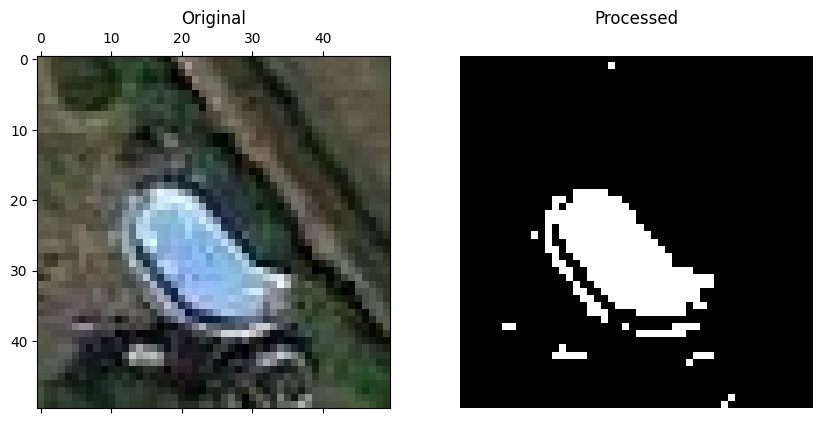

Indice de Jaccard:  0.6360759493670886
Cobertura de imagen: 0.8305785123966942


In [21]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img0.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)


pipe1 = pipeline()
pipe1.add_operation(kmeans_segmentation)
pipe1.add_operation(otsu_threshold)
binary = pipe1.apply(image_rgb, False)
display_image_mask(image_rgb, binary, title=pipe1)

results_path = os.path.join('..', 'results', 'pool_annotation_train_img-0-30.csv')
mask = obtain_measured_mask('img0.jpg', results_path, gray.shape)

print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))


ImageProcessingPipeline: otsu_threshold(kmeans_segmentation(image))


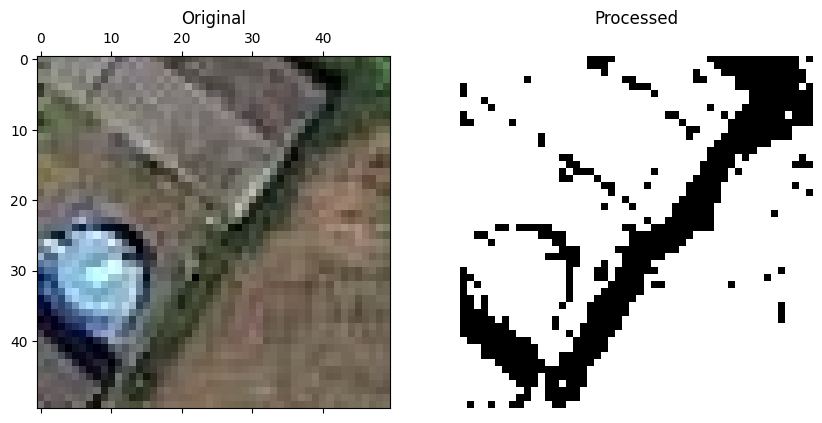

Indice de Jaccard:  0.08610271903323263
Cobertura de imagen: 0.8300970873786407


In [22]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img10.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

pipe1 = pipeline()
pipe1.add_operation(kmeans_segmentation)
pipe1.add_operation(otsu_threshold)
binary = pipe1.apply(image_rgb, False)
display_image_mask(image_rgb, binary, title=pipe1)

results_path = os.path.join('..', 'results', 'pool_annotation_train_img-0-30.csv')
mask = obtain_measured_mask('img10.jpg', results_path, gray.shape)

print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

#### **K-means using Otsu Thresholding and denoising**

Al agregar un paso de eliminación de ruido, se puede observar que el resultado mejora considerablemente, ya que se eliminan los detalles no deseados. Esto se puede observar en el aumento del índice de Jaccard, así como en la propia máscara obtenida. Se refleja este resultado en el aumento del índice de Jaccard obtenido, que significa que se llegó a una aproximación más exacta de la imagen. A su vez, la disminución leve del indice de cobertura significa que la mayoría de los detalles eliminados no son parte de la piscina. Este paso de eliminación de ruido es necesario independientemente del método de segmentación y selección utilizado, ya que en todos los casos se pueden obtener detalles no deseados.


ImageProcessingPipeline: morfology_cleaning(otsu_threshold(kmeans_segmentation(image)))


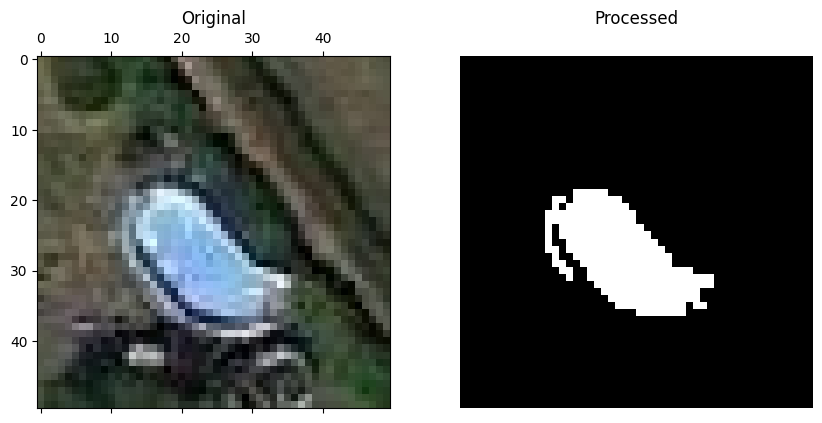

Indice de Jaccard:  0.701067615658363
Cobertura de imagen: 0.8140495867768595


In [23]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img0.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

pipe2 = pipeline()
pipe2.add_operation(kmeans_segmentation)
pipe2.add_operation(otsu_threshold)
pipe2.add_operation(morfology_cleaning)
binary = pipe2.apply(image_rgb, False)

display_image_mask(image_rgb, binary, title=pipe2)

mask = obtain_measured_mask('img0.jpg', results_path, gray.shape)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

#### **Most-Blue-Component-based selection**

Por lo visto anteriormente el método de Otsu y otras formas de thresholding no son suficientes para seleccionar la componente correcta de k-means, ya que en algunos casos la componente más destacada o de mayor tamaño no es la que contiene a la piscina.

Una de las estrategias tomadas para decidir la componente correcta fue elegir la que tuviera mayor intersección con las zonas azules de la imagen, que dada la naturaleza del problema son las que tienen mayor probabilidad de incluir una piscina. Esto se hizo operando en el espacio de color HSV, en que se definió un rango de posibles "tonos azules" en la imagen que incluyan las piscinas buscadas en colores azules de diferente brillo y saturación (ver función $\texttt{keep\_blue}$). Luego, se calculó la intersección de cada componente con este rango, y se eligió la componente con mayor intersección.

#### **Experiment over all images**

En la celda siguiente, en que se muestra el promedio del indice de Jaccard calculado para los resultados obtenidos usando este método, variando el valor de k en k-means. En principio parece que se obtienen valores peores de cobertura para todos los valores de k, pero se observa también que esto se debe a que el método implementado en este caso es considerablemente más restrictivo que el anterior, ya que por ejemplo presenta más casos en que se descartan todas las componentes. Como se observará a continuación también, este método presenta un máximo local alrededor de k=4, pero este valor no lleva necesariamente a mejores resultados. 

In [24]:
def test_k_iterative_mask_result(results_path, k_min, k_max, get_pipeline):
    resultados = []
    pd.set_option('display.precision', 4)
    df = pd.DataFrame(columns=['k', 'mean', 'std', 'max', 'min'])
    for k in range(k_min, k_max):
        pipe = get_pipeline(k)
        resultados_k = test_mask_results(results_path, pipe)
        df.loc[len(df)] = {'k': k, 'mean': np.mean(resultados_k), 'std': np.array(resultados_k).std(), 'max': np.max(resultados_k), 'min': np.min(resultados_k)}
        resultados.append(resultados_k)
    print(df.to_string(index= False))
    return np.array(resultados)

def pipeline_given_k(k):
    pipe = pipeline()
    pipe.add_operation(partial(kmeans_segmentation2, k=k))
    pipe.add_operation(keep_most_blue_component)
    pipe.add_operation(to_grayscale)
    pipe.add_operation(simple_threshold)
    return pipe

results_path = os.path.join('..', 'results', 'pool_annotation_train_img-0-30.csv')
test = test_k_iterative_mask_result(results_path, 2, 15, pipeline_given_k)

 k   mean    std    max    min
 2 0.0965 0.1418 0.6103 0.0005
 3 0.0760 0.1288 0.5115 0.0005
 4 0.0845 0.1490 0.5346 0.0000
 5 0.0353 0.0464 0.2202 0.0000
 6 0.0313 0.0471 0.2484 0.0000
 7 0.0143 0.0171 0.0897 0.0000
 8 0.0126 0.0176 0.0936 0.0000
 9 0.0142 0.0311 0.1733 0.0000
10 0.0105 0.0253 0.1419 0.0000
11 0.0070 0.0129 0.0657 0.0000
12 0.0046 0.0077 0.0290 0.0000
13 0.0029 0.0054 0.0265 0.0000
14 0.0044 0.0124 0.0659 0.0000


Como se observa en la celda anterior, el promedio del indice de Jaccard obtenido no mejora significativamente al aumentar la cantidad de centros usados en k-means. Esto tiene sentido teórico ya que en comparación a los casos de k bajos, es más probable al dividir la imagen en más componentes que una de ellas sea la correspondiente a la piscina, pero también es más probable que la componente elegida no sea la correcta. 

#### **Application example**

La utilidad de este método se verá estudiando casos individuales, por ejemplo en la celda siguiente se muestran los resultados de aplicar los algoritmos anteriores a una misma imagen, con los errores a los que lleva cada uno. En primer lugar, el método de k-means simple con selección mediante el algoritmo de umbralización de Otsu no llega en casos como este a seleccionar la componente correcta, incluso al variar los valores de k.

La selección por componente más azul, por otro lado, es capaz de seleccionar correctamente la componente, pero se debe tener el cuidado de obtener una componente que se ajuste a la región buscada. Puede verse que al usar valores muy bajos de k, se obtiene una componente que no se ajusta a la piscina, ya que la clase devuelta por k-means que contiene la región más azul también contiene un conjunto más amplio de pixeles. Al aumentar k, es posible tener clases más precisas y por lo tanto que la que sea proporcionalmente más azul sea la que contiene la piscina.

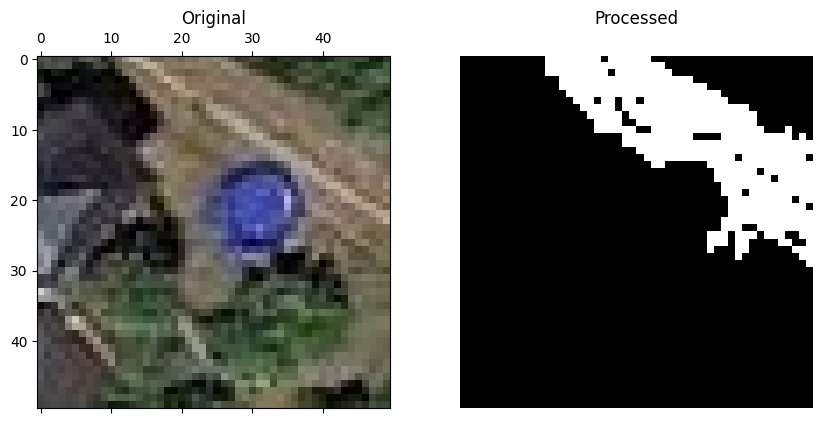

Indice de Jaccard:  0.026578073089700997
Cobertura de imagen: 0.10738255033557047


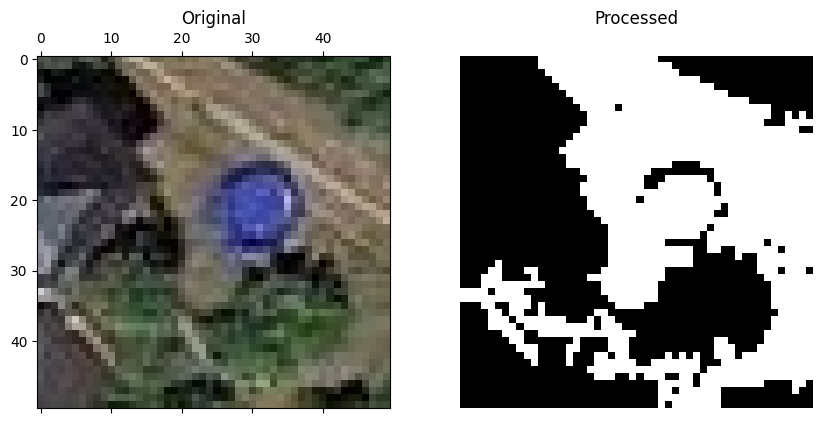

Indice de Jaccard:  0.09172077922077922
Cobertura de imagen: 0.7583892617449665


In [25]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img11.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

mask = obtain_measured_mask('img11.jpg', results_path, gray.shape)

binary = pipe2.apply(imag, False)
display_image_mask(image_rgb, binary)

print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

pipe_k_7 = pipeline()
pipe_k_7.add_operation(partial(kmeans_segmentation, k=8))
pipe_k_7.add_operation(otsu_threshold)
pipe_k_7.add_operation(morfology_cleaning)
binary = pipe_k_7.apply(imag, False)
display_image_mask(image_rgb, binary)

print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

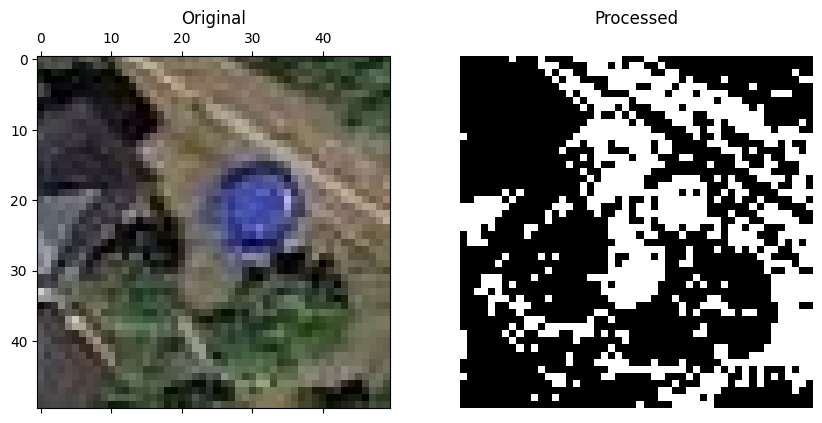

Indice de Jaccard:  0.07521186440677965
Cobertura de imagen: 0.47651006711409394


In [26]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img11.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

mask = obtain_measured_mask('img11.jpg', results_path, gray.shape)

pipe_keep_most_blue = pipeline()
pipe_keep_most_blue.add_operation(partial(kmeans_segmentation2, k=4))
pipe_keep_most_blue.add_operation(keep_most_blue_component)
pipe_keep_most_blue.add_operation(to_grayscale)
pipe_keep_most_blue.add_operation(morfology_cleaning)
binary = pipe_keep_most_blue.apply(image_rgb, False)
display_image_mask(image_rgb, binary)

print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

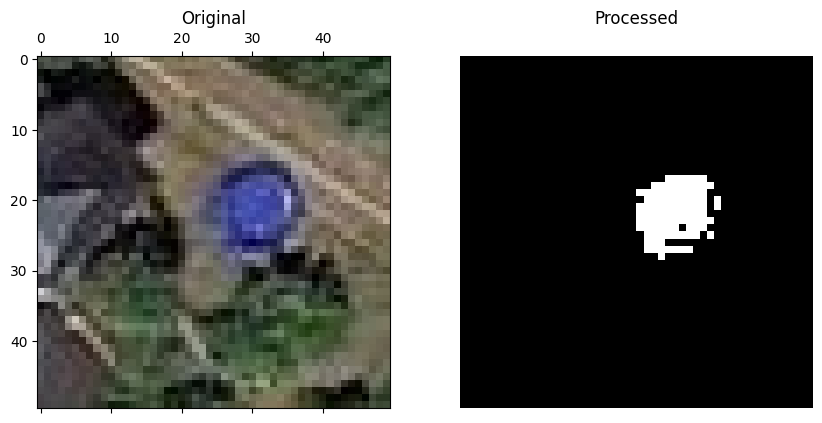

Indice de Jaccard:  0.5408805031446541
Cobertura de imagen: 0.5771812080536913


In [27]:
pipe_keep_most_blue = pipeline()
pipe_keep_most_blue.add_operation(partial(kmeans_segmentation2, k=8))
pipe_keep_most_blue.add_operation(keep_most_blue_component)
pipe_keep_most_blue.add_operation(to_grayscale)
binary = pipe_keep_most_blue.apply(image_rgb, False)
display_image_mask(image_rgb, binary)

print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

En el caso anterior se observa entonces como un valor mayor de k permite la segmentación en componentes más precisas, pero esto también lleva a una mayor granularidad en la segmentación, lo que puede llevar a que la componente elegida pierda cierta cantidad de detalles que disminuyen el indice de Jaccard obtenido por cubrir menos partes de la piscina deseada. Sin embargo esto sigue siendo mejor que el caso en que se usa un valor de k menor, ya que en este caso se pierde precisión en la segmentación, lo que lleva a que la componente elegida incluya una gran cantidad de secciones no deseadas.

Puede verse incluso que la mayor presición en la segmentación obtenida lleva a invalidar las operaciones de eliminación de ruido, ya que en este caso se obtienen componentes demasiado pequeñas que son eliminadas por el filtro de tamaño mínimo o el filtro de otsu, como puede verse en las celdas siguientes. En el caso del filtro de tamaño mínimo esto podría ajustarse cambiando el tamaño de la componente mínima, pero intentar calibrar este valor en función del conjunto de datos para obtener mejores resultados sería una solución muy cercana al sobreajuste. Una operación análoga no es posible en el caso del filtro de otsu, ya que este depende de la imagen y no de la componente. 

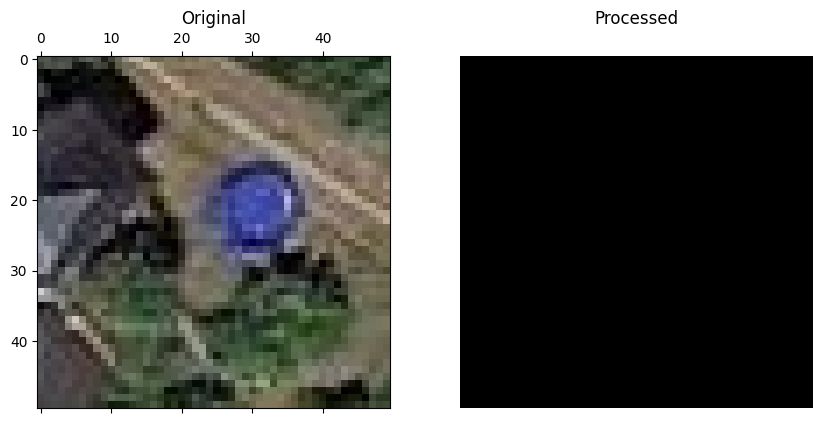

Indice de Jaccard:  0.0
Cobertura de imagen: 0.0


In [28]:
pipe_keep_most_blue_clean = pipeline()
pipe_keep_most_blue_clean.add_operation(partial(kmeans_segmentation2, k=8))
pipe_keep_most_blue_clean.add_operation(keep_most_blue_component)
pipe_keep_most_blue_clean.add_operation(to_grayscale)
pipe_keep_most_blue_clean.add_operation(morfology_cleaning)
binary = pipe_keep_most_blue_clean.apply(image_rgb, False)
display_image_mask(image_rgb, binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

Por las celdas anteriores se distingue entonces que el método de selección de componente "más azul" es más restrictivo en los resultados obtenidos, y por más que este sea más preciso en cuanto a la posición y forma general de la componente correspondiente a la piscina, este método tiende a descartar secciones deseadas de dicha componente, generando "huecos" que empeoran la cobertura obtenida. Una posible solución a este problema es expandir la selección obtenida y luego erosionarla para rellenar estos "huecos". Como puede verse en los ejemplos a continuación esto lleva a una mejor cobertura, pero sin salirse de la misma región que se obtenía con el método anterior.

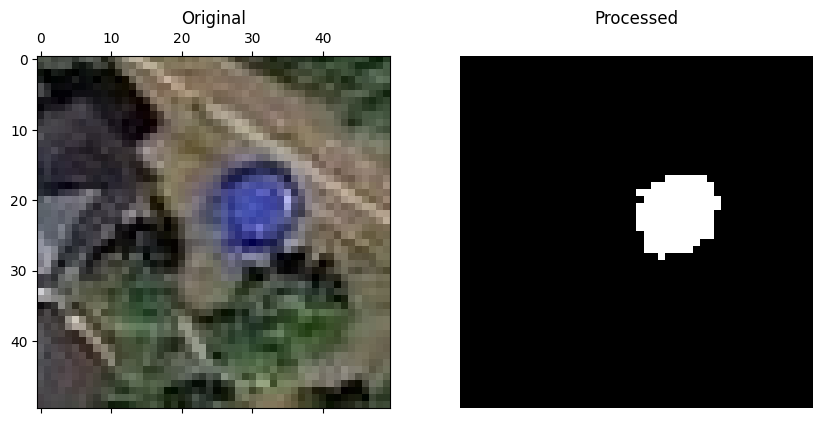

Indice de Jaccard:  0.6163522012578616
Cobertura de imagen: 0.6577181208053692


In [29]:
pipe_keep_most_blue_absorb = pipeline()
pipe_keep_most_blue_absorb.add_operation(partial(kmeans_segmentation2, k=8))
pipe_keep_most_blue_absorb.add_operation(keep_most_blue_component)
pipe_keep_most_blue_absorb.add_operation(to_grayscale)
pipe_keep_most_blue_absorb.add_operation(morfology_absorption)
binary = pipe_keep_most_blue_absorb.apply(image_rgb, False)
display_image_mask(image_rgb, binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

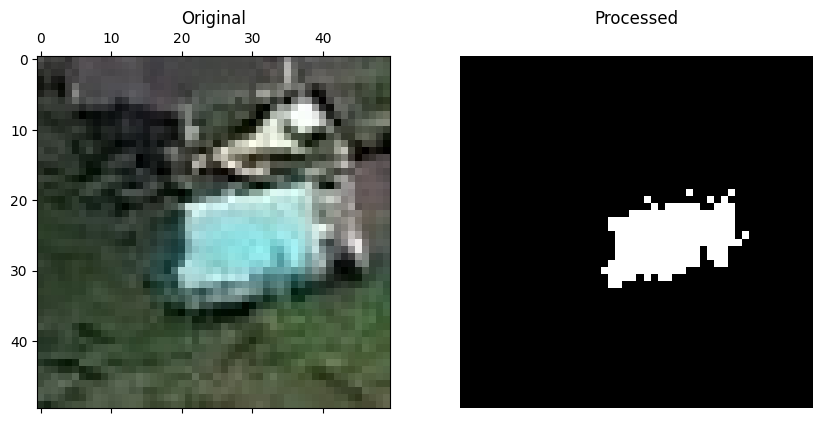

Indice de Jaccard:  0.649402390438247
Cobertura de imagen: 0.659919028340081


In [30]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img5.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

mask = obtain_measured_mask('img5.jpg', results_path, gray.shape)

binary = pipe_keep_most_blue.apply(image_rgb, False)
display_image_mask(image_rgb, binary)

print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

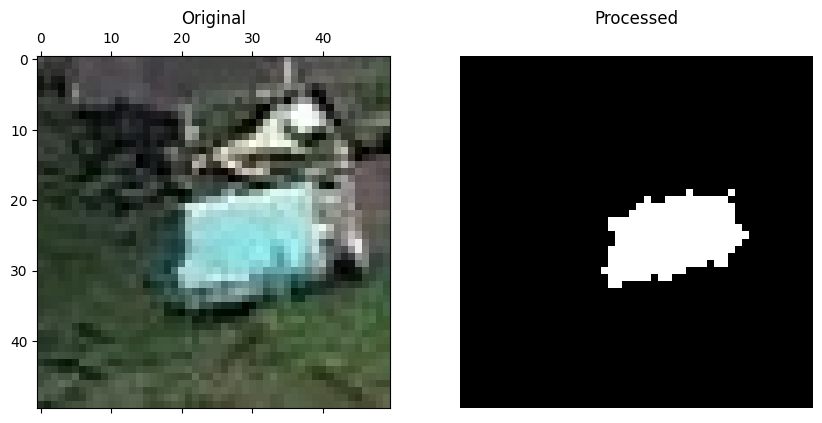

Indice de Jaccard:  0.7261904761904762
Cobertura de imagen: 0.7408906882591093


In [31]:
binary = pipe_keep_most_blue_absorb.apply(image_rgb, False)
display_image_mask(image_rgb, binary)

print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

En el ejemplo siguiente puede verse también como esta técnica mejora los resultados en los casos en que la piscina no es de color azul completamente, ya que en estos casos el método rellena los huecos que este tipo de piscinas causan en las componentes halladas mediante k-means.

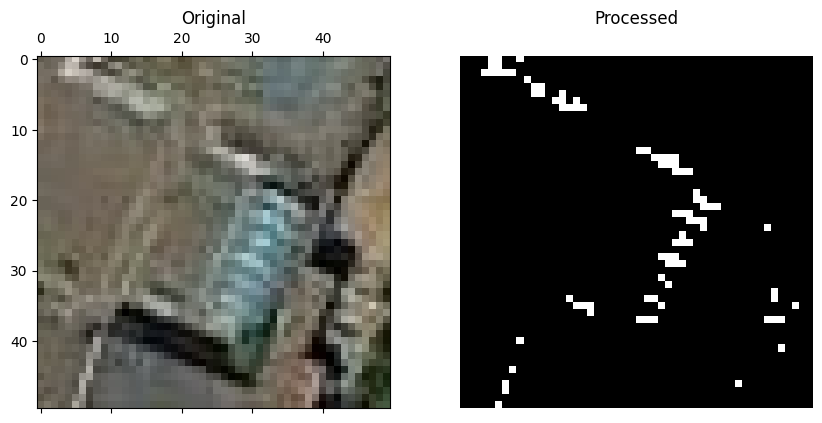

Indice de Jaccard:  0.11481481481481481
Cobertura de imagen: 0.14351851851851852


In [32]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img13.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

mask = obtain_measured_mask('img13.jpg', results_path, gray.shape)

binary = pipe_keep_most_blue.apply(image_rgb, False)
display_image_mask(image_rgb, binary)

print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

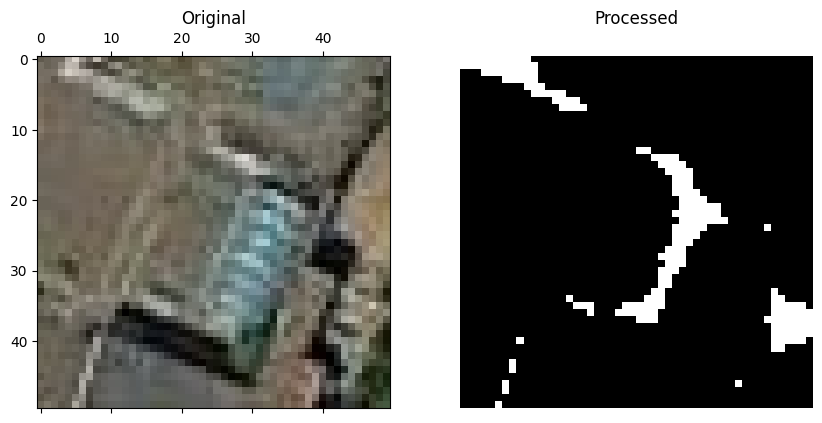

Indice de Jaccard:  0.21994134897360704
Cobertura de imagen: 0.3472222222222222


In [33]:
binary = pipe_keep_most_blue_absorb.apply(image_rgb, False)
display_image_mask(image_rgb, binary)

print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

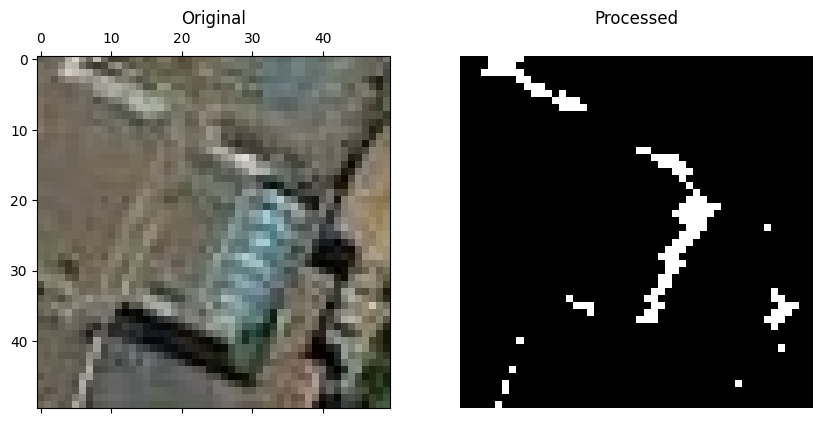

Indice de Jaccard:  0.1903114186851211
Cobertura de imagen: 0.25462962962962965


In [34]:
pipe_keep_most_blue_absorb = pipeline()
pipe_keep_most_blue_absorb.add_operation(partial(kmeans_segmentation2, k=8))
pipe_keep_most_blue_absorb.add_operation(keep_most_blue_component)
pipe_keep_most_blue_absorb.add_operation(to_grayscale)
pipe_keep_most_blue_absorb.add_operation(partial(morfology_absorption, size=2))
binary = pipe_keep_most_blue_absorb.apply(image_rgb, False)
display_image_mask(image_rgb, binary)

print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

### K-MEANS (HSV)


Dados los resultados obtenidos en el espacio de color RGB, se decidió probar el mismo método en el espacio de color HSV, ya que como se observó anteriormente, este espacio de color permite una mejor separación de los colores por tono, lo que puede ayudar a la segmentación. Se puede estudiar de esta manera el impacto de los métodos utilizados en el algoritmo de segmentación al separar mediante k-means en diferentes clases en este nuevo espacio de color.

El razonamiento para este cambio de espacio de color de la entrada al algoritmo es que este espacio se basa en la separación de los colores por tono, lo que separa de forma considerablemente diferente las clases de color buscadas. Esto por lo tanto puede llevar a que la iteración de k-means separe de forma diferente las clases buscadas, lo que puede llevar a una mejor segmentación si estas son más ajustadas a las regiones buscadas en la imagen.

#### **K-MEANS SIMPLE**

En primer lugar interesa comparar el funcionamiento del algoritmo de k-means por si solo al tener como entrada una imagen en el espacio HSV, para saber si esto llevará a cambios significativos en los resultados obtenidos en cuanto a la forma y distribución de las clases. Como puede verse en los resultados siguientes, al aplicar k-means en este espacio de color es generalmente posible aproximar a la piscina buscada mediante una de las clases que retorna k-means, incluso en diferentes valores de k. La principal diferencia respecto a la aplicación en RGB parece ser como el algoritmo segmenta y agrupa el resto de la imagen.


ImageProcessingPipeline: kmeans_segmentation(to_hsv(image))


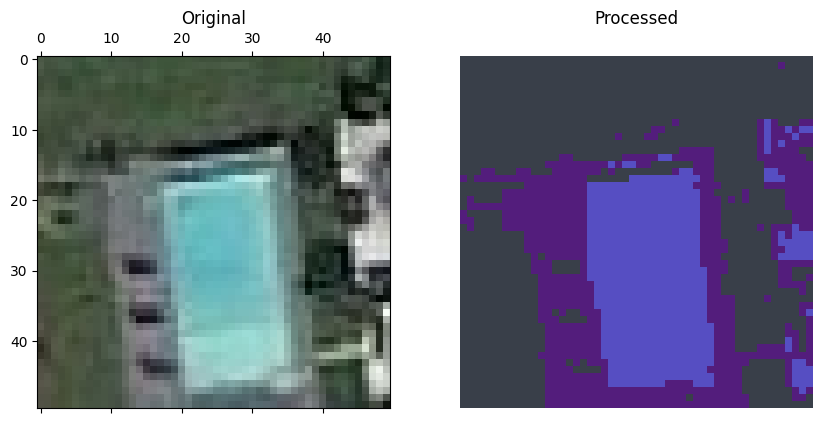


kmeans_segmentation(to_hsv(image))


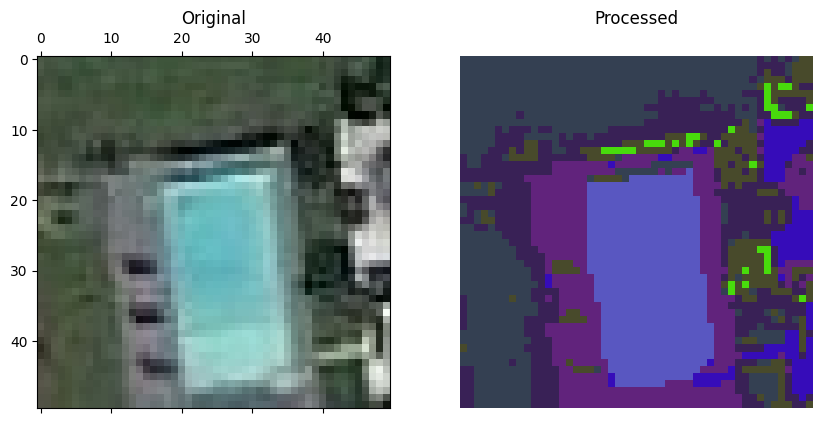

In [35]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img12.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

pipe1_hsv = pipeline()
pipe1_hsv.add_operation(to_hsv)
pipe1_hsv.add_operation(kmeans_segmentation)
segmented = pipe1_hsv.apply(image_rgb, False)
display_image_mask(image_rgb, segmented, title=pipe1_hsv)

pipe2_hsv = pipeline()
pipe2_hsv.add_operation(to_hsv)
pipe2_hsv.add_operation(partial(kmeans_segmentation, k=7))
segmented = pipe2_hsv.apply(image_rgb, False)
display_image_mask(image_rgb, segmented, title="kmeans_segmentation(to_hsv(image))")


ImageProcessingPipeline: otsu_threshold(kmeans_segmentation(image))


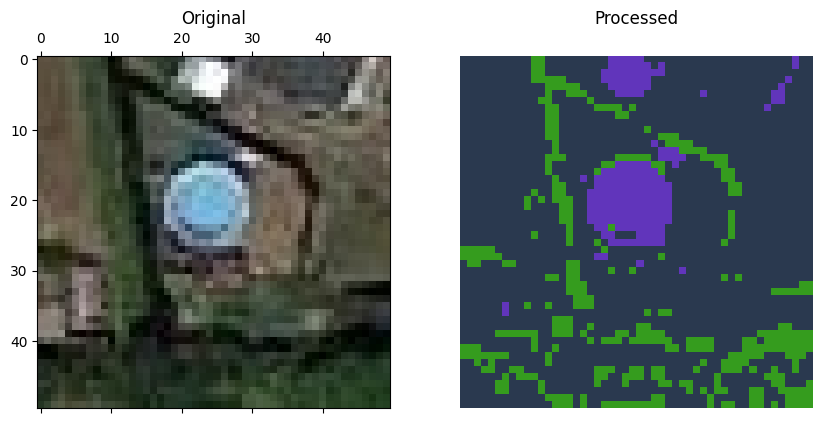


kmeans_segmentation(to_hsv(image))


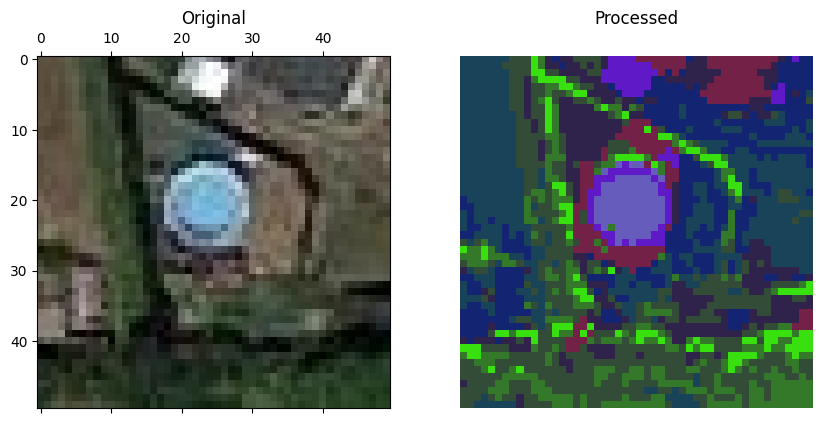

In [36]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img2.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

segmented = pipe1_hsv.apply(image_rgb, False)
display_image_mask(image_rgb, segmented, title=pipe1)

pipe3_hsv = pipeline()
pipe3_hsv.add_operation(to_hsv)
pipe3_hsv.add_operation(partial(kmeans_segmentation, k=9))
segmented = pipe3_hsv.apply(image_rgb, False)
display_image_mask(image_rgb, segmented, title="kmeans_segmentation(to_hsv(image))")

#### **K-MEANS using Otsu thresholding**

Al aplicar al resultado de k-means el método de Otsu para thresholding, se puede observar que en algunos casos se obtienen resultados similares a los obtenidos en el espacio de color RGB, ya que en algunos casos se obtiene una componente que contiene la piscina buscada, y en otros esta no resulta ser la componente destacada por la umbralización de Otsu. Esto tiene sentido con lo visto anteriormente, ya que aplicar k-Means en este nuevo espacio de color no hace que la clase buscada destaque más en la imagen, por lo que se debe buscar un nuevo algoritmo de selección.


ImageProcessingPipeline: morfology_cleaning(otsu_threshold(kmeans_segmentation(to_hsv(image))))


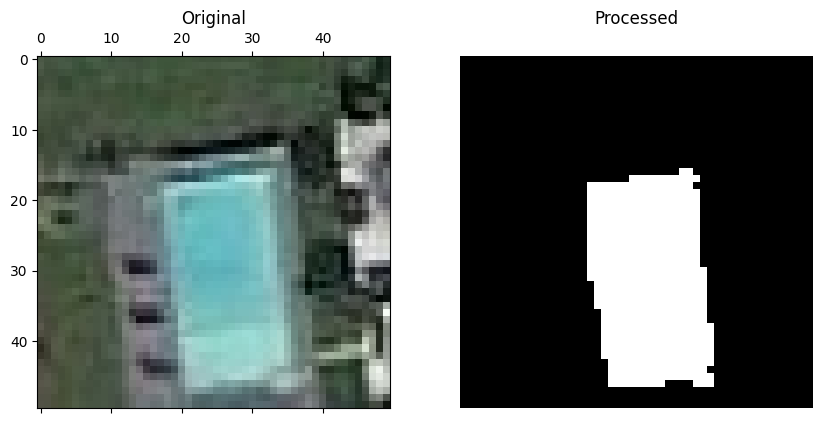

Indice de Jaccard:  0.8606403013182674
Cobertura de imagen: 0.8754789272030651

morfology_cleaning(otsu_threshold(kmeans_segmentation(to_hsv(image))))


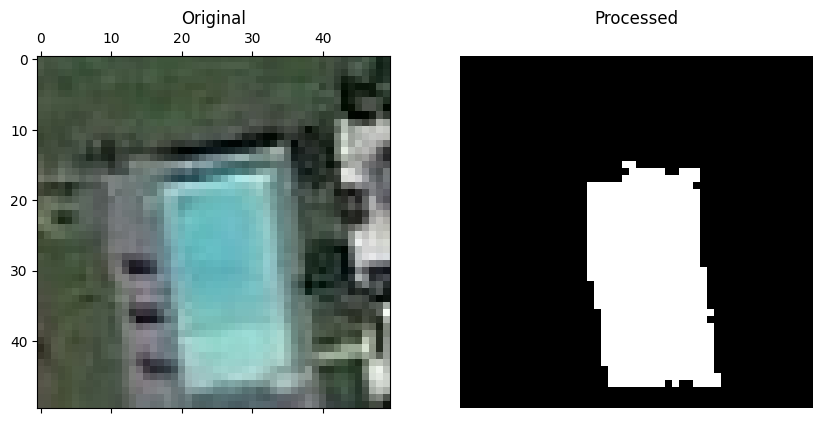

Indice de Jaccard:  0.871268656716418
Cobertura de imagen: 0.8946360153256705


In [37]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img12.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

mask = obtain_measured_mask('img12.jpg', results_path, gray.shape)

pipe_otsu_hsv = pipeline()
pipe_otsu_hsv.add_operation(to_hsv)
pipe_otsu_hsv.add_operation(kmeans_segmentation)
pipe_otsu_hsv.add_operation(otsu_threshold)
pipe_otsu_hsv.add_operation(morfology_cleaning)
binary = pipe_otsu_hsv.apply(image_rgb, False)

display_image_mask(image_rgb, binary, title=pipe_otsu_hsv)

print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

pipe_otsu_hsv_2 = pipeline()
pipe_otsu_hsv_2.add_operation(to_hsv)
pipe_otsu_hsv_2.add_operation(partial(kmeans_segmentation, k=7))
pipe_otsu_hsv_2.add_operation(otsu_threshold)
pipe_otsu_hsv_2.add_operation(morfology_cleaning)
binary = pipe_otsu_hsv_2.apply(image_rgb, False)

display_image_mask(image_rgb, binary, title="morfology_cleaning(otsu_threshold(kmeans_segmentation(to_hsv(image))))")

print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))


morfology_cleaning(otsu_threshold(kmeans_segmentation(to_hsv(image))))


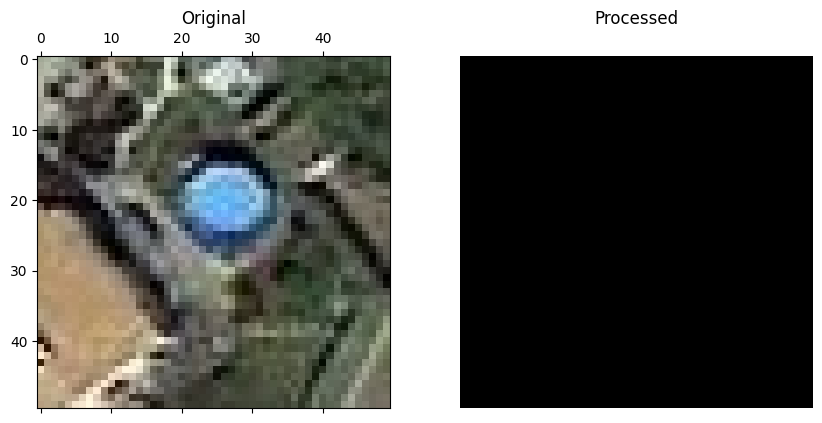

Indice de Jaccard:  0.0
Cobertura de imagen: 0.0


In [38]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img9.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

mask = obtain_measured_mask('img9.jpg', results_path, gray.shape)

binary = pipe_otsu_hsv_2.apply(image_rgb, False)

display_image_mask(image_rgb, binary, title="morfology_cleaning(otsu_threshold(kmeans_segmentation(to_hsv(image))))")

print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

#### **HSV using most blue component**

Resta entonces incorporar el método de selección de componente diseñado, y al hacer esto se observan resultados similares a los dados en el espacio RGB. Esto se debe principalmente a que bajo los parámetros utilizados, en muchos casos el rango de tonos azules buscados no está tanto más diferenciado del resto de colores en la imagen en el espacio HSV como podría estar en RGB, por lo que la segmentación llega a resultados similares. Se ven incluso efectos similares como la tendencia a descartar pixeles en vez de incluirlos, por lo que se puede aplicar la misma solución de rellenar los huecos obtenidos mediante una operación de dilatación. 

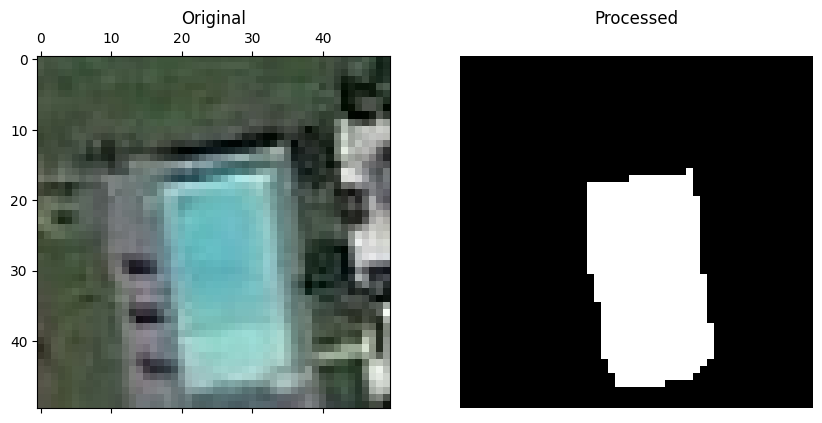

Indice de Jaccard:  0.8444022770398482
Cobertura de imagen: 0.8524904214559387


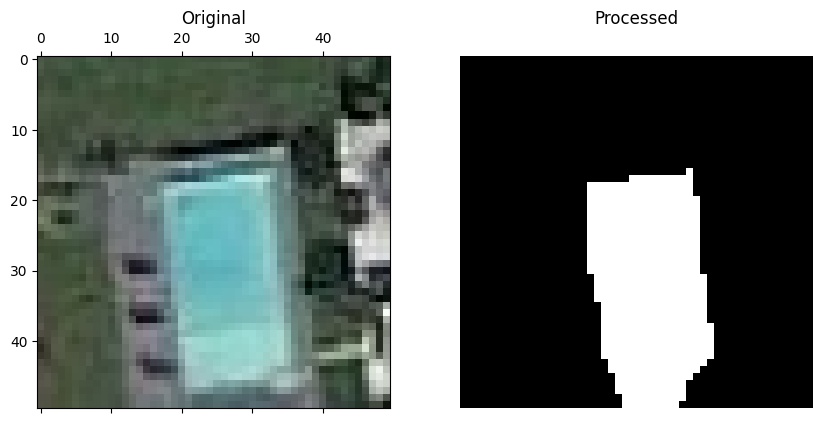

Indice de Jaccard:  0.825136612021858
Cobertura de imagen: 0.867816091954023


In [39]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img12.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

mask = obtain_measured_mask('img12.jpg', results_path, gray.shape)

pipe_keep_most_blue_hsv = pipeline()
pipe_keep_most_blue_hsv.add_operation(to_hsv)
pipe_keep_most_blue_hsv.add_operation(partial(kmeans_segmentation2, k=7))
pipe_keep_most_blue_hsv.add_operation(partial(keep_most_blue_component, is_hsv=True))
pipe_keep_most_blue_hsv.add_operation(to_grayscale)
binary = pipe_keep_most_blue_hsv.apply(image_rgb, False)
display_image_mask(image_rgb, binary)

print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

pipe_keep_most_blue_absorb_hsv = pipeline()
pipe_keep_most_blue_absorb_hsv.add_operation(to_hsv)
pipe_keep_most_blue_absorb_hsv.add_operation(partial(kmeans_segmentation2, k=7))
pipe_keep_most_blue_absorb_hsv.add_operation(partial(keep_most_blue_component, is_hsv=True))
pipe_keep_most_blue_absorb_hsv.add_operation(to_grayscale)
pipe_keep_most_blue_absorb_hsv.add_operation(morfology_absorption)
binary = pipe_keep_most_blue_absorb_hsv.apply(image_rgb, False)
display_image_mask(image_rgb, binary)

print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

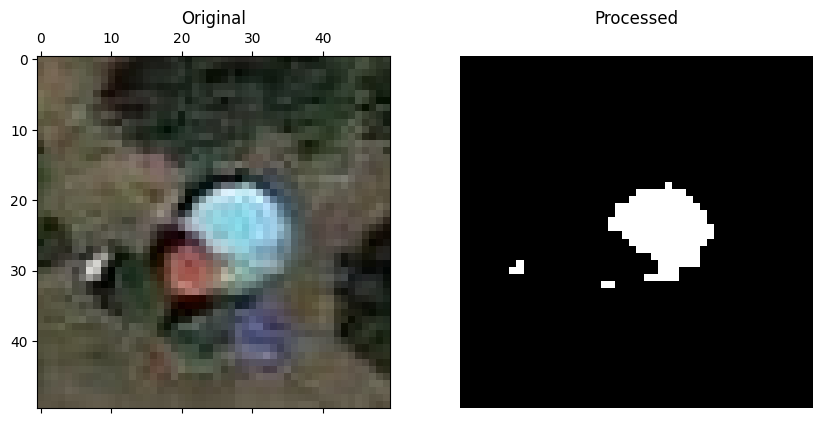

Indice de Jaccard:  0.718562874251497
Cobertura de imagen: 0.7643312101910829


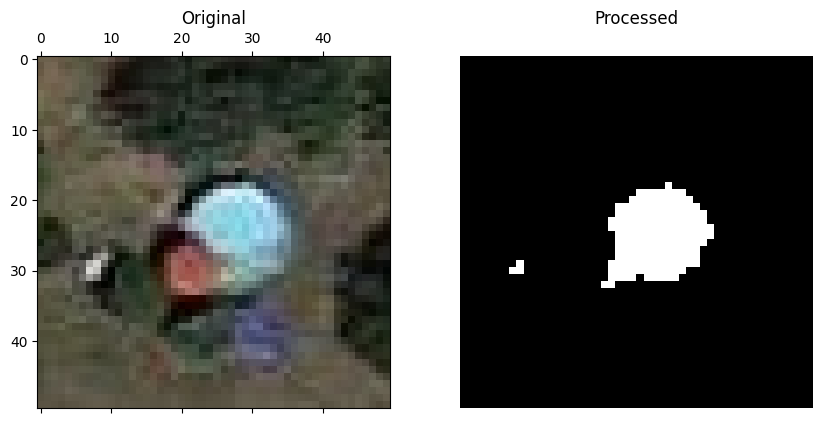

Indice de Jaccard:  0.6596858638743456
Cobertura de imagen: 0.802547770700637


In [40]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img7.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

mask = obtain_measured_mask('img7.jpg', results_path, gray.shape)

pipe_keep_most_blue_hsv = pipeline()
pipe_keep_most_blue_hsv.add_operation(to_hsv)
pipe_keep_most_blue_hsv.add_operation(partial(kmeans_segmentation2, k=7))
pipe_keep_most_blue_hsv.add_operation(partial(keep_most_blue_component, is_hsv=True))
pipe_keep_most_blue_hsv.add_operation(to_grayscale)
binary = pipe_keep_most_blue_hsv.apply(image_rgb, False)
display_image_mask(image_rgb, binary)

print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

pipe_keep_most_blue_absorb_hsv = pipeline()
pipe_keep_most_blue_absorb_hsv.add_operation(to_hsv)
pipe_keep_most_blue_absorb_hsv.add_operation(partial(kmeans_segmentation2, k=7))
pipe_keep_most_blue_absorb_hsv.add_operation(partial(keep_most_blue_component, is_hsv=True))
pipe_keep_most_blue_absorb_hsv.add_operation(to_grayscale)
pipe_keep_most_blue_absorb_hsv.add_operation(morfology_absorption)
binary = pipe_keep_most_blue_absorb_hsv.apply(image_rgb, False)
display_image_mask(image_rgb, binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

### **Comparison**

En este caso puede verse un ejercicio similar de estudiar el promedio de resultados del indice de Jaccard entre la máscara medida a mano y las obtenidas para diferentes valores de k en k-means, pero en este caso se estudia el espacio de color HSV. Como se observa en la celda siguiente, se obtienen resultados similares a los obtenidos en el espacio de color RGB, ya que como se vio no se dan cambios significativos en la separación de las diferentes clases mediante k-means.

En ambos casos se presentan promedios generalmente bajos. Una de las razones para esto se puede deber al sesgo que agregan los casos en que se selecciona la componente equivocada, ya que en estos casos se tiene un valor de indice 0, y por otro lado al seleccionar correctamente igual no se tienen valores tan altos por la diferencia entre las áreas seleccionadas. Como se vio en ejemplos anteriores, en muchos de estos en que la región obtenida es correcta, esta igualmente no es tan ajustada a la región marcada manualmente, por más que también sea correcta.

In [41]:
def pipeline_given_k_hsv(k):
    pipe = pipeline()
    pipe.add_operation(to_hsv)
    pipe.add_operation(partial(kmeans_segmentation2, k=k))
    pipe.add_operation(partial(keep_most_blue_component, is_hsv=True))
    pipe.add_operation(to_grayscale)
    pipe.add_operation(morfology_absorption)
    return pipe

results_path = os.path.join('..', 'results', 'pool_annotation_train_img-0-30.csv')
test = test_k_iterative_mask_result(results_path, 2, 15, pipeline_given_k)

 k   mean    std    max    min
 2 0.0962 0.1417 0.6103 0.0005
 3 0.0761 0.1276 0.5109 0.0005
 4 0.0859 0.1490 0.5360 0.0000
 5 0.0348 0.0452 0.2150 0.0000
 6 0.0281 0.0357 0.1686 0.0000
 7 0.0131 0.0170 0.0851 0.0000
 8 0.0166 0.0281 0.1493 0.0000
 9 0.0096 0.0172 0.0927 0.0000
10 0.0101 0.0268 0.1505 0.0000
11 0.0098 0.0249 0.1385 0.0000
12 0.0060 0.0150 0.0809 0.0000
13 0.0046 0.0119 0.0626 0.0000
14 0.0018 0.0026 0.0109 0.0000


## **Observed Difficulties**

Los algoritmos de segmentación estudiados presentan dificultades en la segmentación de las piscinas, ya que en muchos casos no se obtiene una componente que se ajuste a la región buscada. Se fueron presentando diferentes métodos para aliviar esta dificultad, pero de igual manera estos aún presentan algunos casos en que no se obtiene una segmentación correcta.

Por ejemplo, los casos en que la piscina no es de color azul, o en que la piscina es de color azul pero no se encuentra en el rango de tonos azules buscados, son casos en que los métodos estudiados no son capaces de segmentar correctamente la piscina. Esto sucede principalmente en imágenes que presentan piscinas en colores celestes muy claros, o incluso blancas. Este tipo de casos representan un caso borde que puede ser problemático de implementar, ya que el incluir tonos demasiado claros en las regiones buscadas corre el riesgo de incluir otros objetos de la imagen. Al mantenerse en un rango de azul, como este segmentador será aplicado en imágenes que se tiene una suficiente certeza de que contienen piscinas, se puede asumir que la piscina buscada será de un color azul y generalmente destacado respecto a otros tonos azules de la imagen. Por estas razones, en este tipo de casos se prefirió no devolver una componente si no hay presente una región azul en la imagen, ya que en la mayor parte de casos se trataría de falsos positivos, o casos de mala iluminación o saturación en la imagen que igualmente llevarían a devolver un resultado erróneo.

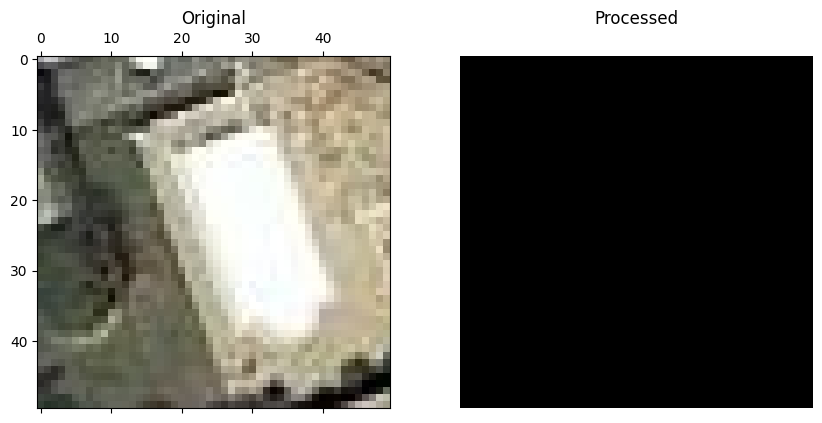

Indice de Jaccard:  0.0
Cobertura de imagen: 0.0


In [42]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img20.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

mask = obtain_measured_mask('img20.jpg', results_path, gray.shape)

pipe_keep_most_blue_clean = pipeline()
pipe_keep_most_blue_clean.add_operation(partial(kmeans_segmentation2, k=8))
pipe_keep_most_blue_clean.add_operation(keep_most_blue_component)
pipe_keep_most_blue_clean.add_operation(to_grayscale)
pipe_keep_most_blue_clean.add_operation(morfology_absorption)
binary = pipe_keep_most_blue_clean.apply(image_rgb, False)
display_image_mask(image_rgb, binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

## **Mask measurement**

A continuación se presenta una función dada devuelve varias medidas de una región de interés en una imagen binaria:

1. **Área**: Mide el tamaño total de la región de interés en metros cuadrados. Es equivalente a la cantidad de píxeles en la región, convertidos a metros cuadrados mediante el factor de conversión proporcionado.

2. **Perímetro**: Mide la longitud total del contorno de la región de interés en metros. Es equivalente a la cantidad de píxeles a lo largo del contorno de la región, convertidos a metros mediante el factor de conversión proporcionado.

3. **Excentricidad**: Esta es una medida de cuánto la forma de la región de interés se desvía de un círculo perfecto. Es un valor escalar que varía de 0 a 1, donde 0 indica un círculo perfecto y valores cercanos a 1 indican formas más alargadas.

4. **Diámetro Equivalente**: Esta es la medida del diámetro de un círculo que tiene el mismo área que la región de interés. Se mide en metros, obtenidos al convertir los píxeles a metros mediante el factor de conversión proporcionado.

In [43]:
def print_metrics(binary, pixel_to_meter_ratio):
    # Label the largest object in the image
    labels = measure.label(binary)
    largest_object = np.argmax(np.bincount(labels.flat)[1:]) + 1

    # Create a mask 
    pool_mask = labels == largest_object

    props = measure.regionprops(pool_mask.astype(int))
    prop = props[0]
    area = prop.area * (pixel_to_meter_ratio**2)  # square the ratio for area
    perimeter = prop.perimeter * pixel_to_meter_ratio  # apply the ratio for perimeter
    eccentricity = prop.eccentricity
    equivalent_diameter = prop.equivalent_diameter * pixel_to_meter_ratio  # apply the ratio for diameter

    print( "Area: {:.4f} square meters".format(area))
    print( "Perimeter: {:.4f} meters".format(perimeter))
    print( "Eccentricity: {:.4f}".format(eccentricity))
    print( "Equivalent Diameter: {:.4f} meters".format(equivalent_diameter))

Luego se listan algunos ejemplos aplicados sobre algunas de las mascaras generadas sobre las imagenes de prueba. Se puede observar que las medidas de excentricidad son bastante adecuadas para distinguir las piscinas circulares de las más alargadas. Sin embargo, esto no es suficiente para distinguir las piscinas de otras cuadradas de las de borde redondeado.

Respecto a las unidades de área y perímetro, estas dan resultados bastante razonables al medirlas en pixeles. En caso de tener la relación pixeles a metros de estas imágenes, sería posible hacer una conversión de estos resultados a metros.

Area: 9.6800 square meters
Perimeter: 12.6711 meters
Eccentricity: 0.8408
Equivalent Diameter: 3.5107 meters


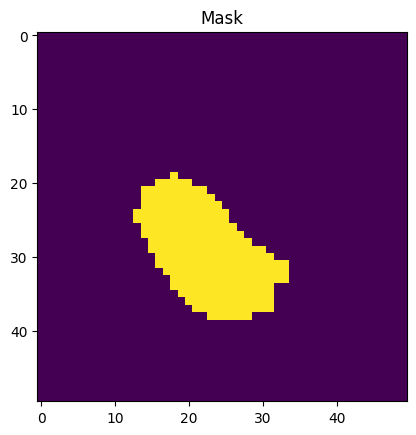

Area: 8.2000 square meters
Perimeter: 10.1255 meters
Eccentricity: 0.3382
Equivalent Diameter: 3.2312 meters


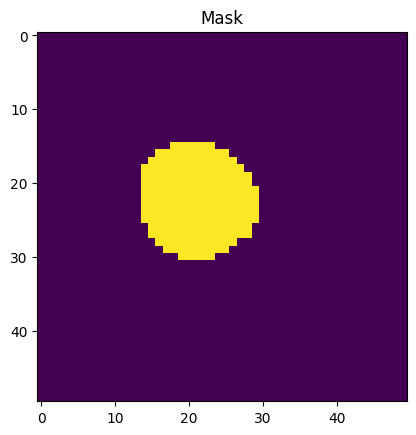

Area: 5.1200 square meters
Perimeter: 8.0770 meters
Eccentricity: 0.3148
Equivalent Diameter: 2.5532 meters


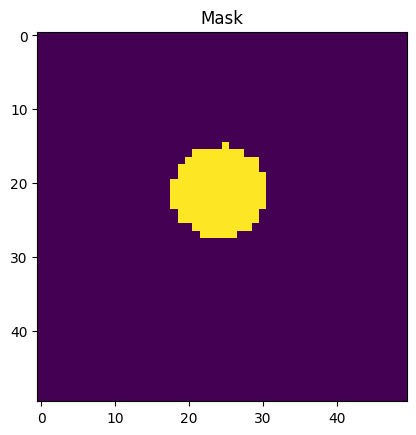

Area: 6.2800 square meters
Perimeter: 9.4083 meters
Eccentricity: 0.7095
Equivalent Diameter: 2.8277 meters


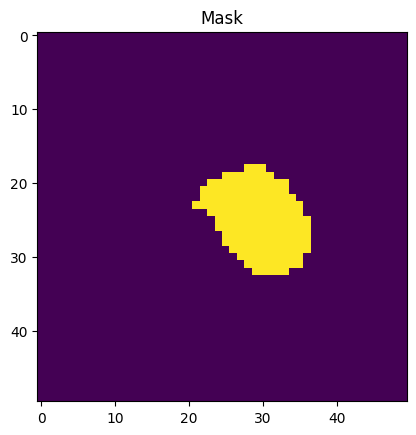

Area: 29.8400 square meters
Perimeter: 23.8250 meters
Eccentricity: 0.8771
Equivalent Diameter: 6.1639 meters


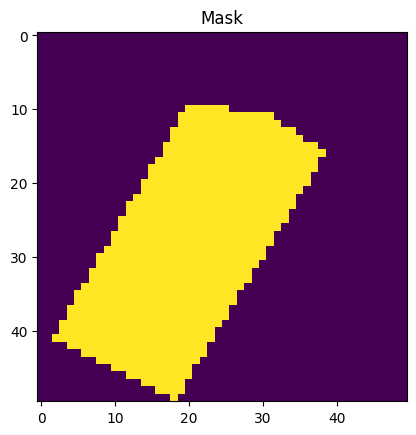

In [44]:
image_bgr = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img20.jpg'))
gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
mask = obtain_measured_mask('img0.jpg', TAGGED_IMAGES_PATH, gray.shape)
print_metrics(mask, 0.2)
plt.figure()
plt.imshow(mask)
plt.title("Mask")
plt.show()


mask = obtain_measured_mask('img1.jpg', TAGGED_IMAGES_PATH, gray.shape)
print_metrics(mask, 0.2)
plt.figure()
plt.imshow(mask)
plt.title("Mask")
plt.show()


mask = obtain_measured_mask('img2.jpg', TAGGED_IMAGES_PATH, gray.shape)
print_metrics(mask, 0.2)
plt.figure()
plt.imshow(mask)
plt.title("Mask")
plt.show()

mask = obtain_measured_mask('img7.jpg', TAGGED_IMAGES_PATH, gray.shape)
print_metrics(mask, 0.2)
plt.figure()
plt.imshow(mask)
plt.title("Mask")
plt.show()

mask = obtain_measured_mask('img15.jpg', TAGGED_IMAGES_PATH, gray.shape)
print_metrics(mask, 0.2)
plt.figure()
plt.imshow(mask)
plt.title("Mask")
plt.show()